## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

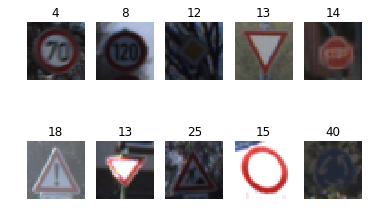

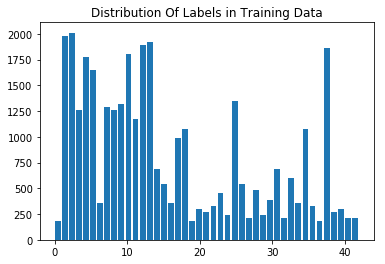

In [3]:
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Map Index to Signnames
signnames = pd.read_csv("signnames.csv")
signnames = {k: v for k, v in zip(signnames['ClassId'], signnames['SignName'])}

for i in range(0, 10):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(y_train[index])
    plt.imshow(image)
plt.show()

plt.hist(y_train, bins=n_classes, width=0.8)
plt.title("Distribution Of Labels in Training Data")
plt.show()

----

## Step 2: Design and Test a Model Architecture

We design and implement a deep learning model that learns to recognize traffic signs. Then we train and test our model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


We use the default LeNet-5 architecture, just preprocess the data to produce a better accuracy

### Pre-process the Data Set (normalization, data augmentation, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

We also combine all the data and reshuffle it to create the validation and test data sets. We could use data augmentation techniques to generate more data and further improve the accuracy.

In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

# Combine all the data
X_train = np.concatenate((X_train, X_valid, X_test), axis=0)
y_train = np.concatenate((y_train, y_valid, y_test), axis=0)

# Reshuffle it to create a new set
X_train, y_train = shuffle(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# shuffle and split again for training set and valid set
X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=45)

def normalize(pixel):
    return (pixel - 128.0) / 128.0

X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test  = normalize(X_test)

### Model Architecture

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 256
rate = 0.002

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [6]:
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32,name="keep_prob")
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x, keep_prob=keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.716

EPOCH 2 ...
Validation Accuracy = 0.876

EPOCH 3 ...
Validation Accuracy = 0.931

EPOCH 4 ...
Validation Accuracy = 0.945

EPOCH 5 ...
Validation Accuracy = 0.946

EPOCH 6 ...
Validation Accuracy = 0.961

EPOCH 7 ...
Validation Accuracy = 0.964

EPOCH 8 ...
Validation Accuracy = 0.960

EPOCH 9 ...
Validation Accuracy = 0.966

EPOCH 10 ...
Validation Accuracy = 0.969

Model saved


In [7]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.973


---

## Step 3: Test a Model on New Images

For a better insight on how the model is working, we download five pictures of German traffic signs from the web and use our model to predict the traffic sign type.

### Load and Output the Images

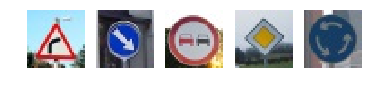

In [8]:
import os
import cv2

# Read Images from Web
images_from_web = os.listdir("images_from_web/")
i = 0
X_samples = np.ndarray(shape=(len(images_from_web) ,32,32,3))
y_samples = np.array([20, 38, 9, 12, 40])
for each_image in images_from_web:
    image = cv2.imread("images_from_web/" + each_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(image)
    #image = np.sum(image/3, axis=2, keepdims=True)
    X_samples[i] = normalize(image)
    i += 1 
plt.show()

### Predict the Sign Type for Each Image

In [9]:
### Run the predictions here and use the model to output the prediction for each image.
sample_predictions = tf.argmax(logits, 1)
sample_softmax = tf.nn.softmax(logits=logits)
sample_top_five = tf.nn.top_k(sample_softmax, k=5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    predictions, softmax, top_five = sess.run([sample_predictions, sample_softmax, sample_top_five], feed_dict={x:X_samples, keep_prob:1.0})
print("Predictions :-")
for prediction in predictions:
    print(signnames[prediction])

INFO:tensorflow:Restoring parameters from .\lenet
Predictions :-
Dangerous curve to the right
Keep right
No passing
Priority road
Roundabout mandatory


### Analyze Performance

In [10]:
### Calculate the accuracy for these 5 new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    test_accuracy = evaluate(X_samples, y_samples)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 1.000


### Top 5 Softmax Probabilities For Each Image Found on the Web

In [11]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.
for k, v in zip(top_five.values, top_five.indices):
    print(k, v)

[  9.99913812e-01   8.00989728e-05   5.58835245e-06   2.25291558e-07
   1.85304941e-07] [20 28 29 27 18]
[  1.00000000e+00   3.95665228e-12   3.15931357e-18   8.93265154e-21
   1.63052202e-28] [38 34 40 36 32]
[  9.99997258e-01   2.73061801e-06   9.99136190e-11   1.49664095e-13
   4.18121043e-14] [ 9 41 35 32 10]
[  1.00000000e+00   4.50889699e-14   3.45092954e-15   2.32545103e-15
   2.51714581e-16] [12 10  6 19 40]
[  9.99818742e-01   6.70600202e-05   4.40261610e-05   3.38272803e-05
   2.94082674e-05] [40 38  6 34 33]
